In [1]:
import glob as gl
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import ks_2samp, kruskal,ttest_ind,spearmanr,pearsonr
from scipy import stats
import seaborn as sns
import shutil

In [2]:
# All metadata
in_folder = "./Protein_data"

# treatments_c = {"Met":1,"AHA":2,"cLTP":3}
subunits = ["GluA1","GluA2"]
subunit_folders = {
    subunits[0]:os.path.join(in_folder,"FUNCAT-Surface-GluA1"),
    subunits[1]:os.path.join(in_folder,"FUNCAT-Surface-GluA2")
                  }
treatments = ["cntl","CNIH2"]
x_labels = ["Control","CNIH-2"]
compartments = ["soma","dendrite"]
CNIH2_gluas_file = os.path.join(in_folder,"CNIH2_gluas_punctas.pkl")
CNIH2_gluas_meta_file = os.path.join(in_folder,"CNIH2_gluas_meta.pkl")

In [3]:
op_folder = "../Figures/CNIH2_AMPAR"
def CreateFolderRecursive(folder):
    """
        function creates folders upto  a path recursively
        arguments : folderpath
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
CreateFolderRecursive(op_folder)

In [4]:
CNIH_gluas_data = pd.read_pickle(CNIH2_gluas_file)
CNIH_gluas_meta_data = pd.read_pickle(CNIH2_gluas_meta_file)
cell_roi_data = CNIH_gluas_data.groupby(["cell_id","subunit","treatment","compartment"])
cell_roi_meta_data = CNIH_gluas_meta_data.groupby(["cell_id","subunit","treatment","compartment"])

In [5]:
cell_roi_data.size(),cell_roi_meta_data.size()

(cell_id  subunit  treatment  compartment
 1        GluA1    CNIH2      dendrite       40
                              soma            1
                   cntl       dendrite       21
                              soma            3
          GluA2    CNIH2      dendrite        9
                                             ..
 44       GluA1    cntl       soma            5
 45       GluA1    cntl       dendrite       28
                              soma            2
 46       GluA1    cntl       dendrite       21
                              soma            3
 Length: 234, dtype: int64,
 cell_id  subunit  treatment  compartment
 1        GluA1    CNIH2      dendrite       14
                              soma            1
                   cntl       dendrite        5
                              soma            1
          GluA2    CNIH2      dendrite        6
                                             ..
 44       GluA1    cntl       soma            1
 45       GluA1    cntl 

In [6]:
def SaveFigures(filename,ext_list = [".png",".svg",".pdf"],dpi=300):
    """
        function to save figures
        required arguments:
            filename
    """
    plt.tight_layout()
    for ext in ext_list:
        plt.savefig(filename+ext,dpi=dpi)
def AnnotateText(ax,x1,x2,y,h,txt,color,ha='center',va='bottom',fsize=24):
        # print(x,y,txt)
        if not txt == '':
            fac = np.abs(x2-x1)*0.04
            trans = ax.get_xaxis_transform()
            plt.hlines(xmin=x1,xmax=x2, y = y+fac, lw=1.5, color=color)#, transform=trans)
            plt.text((x1+ x2)*0.5,y+h+fac,txt, ha=ha, va=va, color=color,fontsize=fsize)#,transform=trans )
def SwarmBoxCombo(dp,x,y,fbase,xlabel,ylabel,title,Num=True,pairs = [[1,2],[3,4]]):
    # for compa in compartments:
        fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
        xfsize = 30
        ax.tick_params(axis='both', which='major', labelsize=xfsize)
        ax.grid(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # comp_to_analyse = compa
        # order = reversed(treatments)
        hue = "treatment"
        hue_order = treatments
        color_pal = ['k','k']
        data_to_plot = dp#dp[dp["compartment"]==comp_to_analyse]
        hue_plot_params = {
                    'data': data_to_plot,
                    'x': x,
                    'y': y,
                    # "order": order,
                    "hue": hue,
                    "hue_order": hue_order,
                    "palette": color_pal,

                }
        # pairs = [
        #     (('E6',tool_list[0]),('E6',tool_list[1])),
        #     (('E7',tool_list[0]),('E7',tool_list[1]))
        #         ]
        sns.swarmplot(**hue_plot_params,
                      dodge=True,
                      zorder=1,
                      size = 10,
                      # kind="strip",
                      # native_scale=True,
                      alpha = 0.5,
                      edgecolor = "k",
                      linewidth = 2,
                      ax=ax)
        sns.boxplot(**hue_plot_params,
                    fill=False,
                    showmeans=True ,
                    meanprops={"marker": "^",
                       "markeredgecolor": "k",
                       "markerfacecolor":"k",
                       "markersize": "20"},
                    medianprops={'color': '#7c0cb4ff', 'ls': '-', 'lw': 4},
                    width=.8,
                    zorder=3,
                    showfliers=False,
                    gap=1.8,
                    ax=ax)
        # sns.swarmplot(**hue_plot_params,
        #               dodge=True,
        #               zorder=1,
        #               size = 10,
        #               # kind="strip",
        #               # native_scale=True,
        #               alpha = 0.5,
        #               edgecolor = "k",
        #               linewidth = 2,
        #               ax=ax)
        # sns.boxplot(**hue_plot_params,
        #             fill=False,
        #             showmeans=True ,
        #             meanprops={"marker": "^",
        #                "markeredgecolor": "k",
        #                "markerfacecolor":"k",
        #                "markersize": "20"},
        #             medianprops={'color': '#7c0cb4ff', 'ls': '-', 'lw': 4},
        #             # width=0.2,
        #             zorder=3,
        #             showfliers=True,
        #             # gap=2.8,
        #             ax=ax)
        if Num:
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Num.apply(list))#.to_numpy()
            # ax.set_ylim([0.2,1])
        else:
            # print(data_to_plot.head())
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Density.apply(list))#.to_numpy()
        # print(len(comp_data[0]),len(comp_data[1]),len(comp_data[2]),len(comp_data[3]))
        # x_pos1 = np.array([-0.2,0.2])
#         alph =0.1
        # x_pos2 = np.array([1-0.2,1+0.2])
        x_poss = [-0.2,0.2,0.8,1.2]
        # x_poss = [[-0.2,.2],[1-0.2,1+0.2]]
#         for i in range(comp_data.shape[1]): 
#             y_plot1 = np.array([comp_data[2,i],comp_data[3,i]])
#             y_plot2 = np.array([comp_data[0,i],comp_data[1,i]])
#             # print(x_pos,y_plot)
#             ax.plot(x_pos1,y_plot1,color='k',alpha=alph)
#             ax.plot(x_pos2,y_plot2,color='k',alpha=alph)
#         # for p in pairs
        
        
        # print(ymax)
        for pdx,pair in enumerate(pairs):
            # print(p_values[p[0]][p[1]])
            ks_res = stats.mannwhitneyu(comp_data[pair[0]-1], comp_data[pair[1]-1])
            print(ks_res.pvalue,comp_data.shape)
            txt = ''
            ymax = np.min([np.max(comp_data[pdx*1+pdx])*1.1,1])
            print(ks_res.pvalue)
            if ks_res.pvalue > 0.05:
                txt= "ns"
            else:
                
                if ks_res.pvalue <= 0.05:
                    txt += '*'
                if ks_res.pvalue <= 0.01:
                    txt += '*'
                if ks_res.pvalue <= 0.001:
                    txt += '*'
            print(txt)
            AnnotateText(ax,x_poss[pair[0]-1],x_poss[pair[1]-1],ymax+0.1*pdx,0.01,txt,'k')
        ax.set_xlabel(xlabel,fontsize=xfsize)
        ax.set_ylabel(ylabel,fontsize=xfsize)
        ax.set_xticks(x_poss,x_labels*2,rotation=45)
        ax.set_title(title,fontsize=xfsize)
        plt.axvline(x=0.5,color = "k",linestyle="--")
        plt.legend([],[],frameon=False)
        ax.set( yscale="log")
        # ax.set_ylim([0,0.25])
        ax.text(x_poss[0],0.2,compartments[0],fontsize=xfsize)
        ax.text(x_poss[2],0.2,compartments[1],fontsize=xfsize)
        SaveFigures("{}/{}".format(op_folder,fbase))
        # annotator = Annotator(ax,pairs=pairs,**hue_plot_params)
        # annotator.configure(test=stat_test, fontsize = xfsize)
        # annotator.apply_and_annotate()
        # sns.swarmplot(data=mRNA_fractions[mRNA_fractions["compartment"]=='neurite'],x="isoform",y='fractions',dodge=True,ax=ax)

        

In [7]:
newprot_counts = CNIH_gluas_data.groupby(["cell_id","subunit","treatment","compartment"]).count().PID
newprot_counts.head()

cell_id  subunit  treatment  compartment
1        GluA1    CNIH2      dendrite       40
                             soma            1
                  cntl       dendrite       21
                             soma            3
         GluA2    CNIH2      dendrite        9
Name: PID, dtype: int64

In [8]:
ROI_areas = cell_roi_meta_data.sum().ROI_AOL
ROI_areas

cell_id  subunit  treatment  compartment
1        GluA1    CNIH2      dendrite       1375.827700
                             soma            116.348256
                  cntl       dendrite        669.709754
                             soma            134.485402
         GluA2    CNIH2      dendrite        359.751674
                                               ...     
44       GluA1    cntl       soma            238.070026
45       GluA1    cntl       dendrite        347.099931
                             soma            148.294226
46       GluA1    cntl       dendrite        243.511655
                             soma            134.915775
Name: ROI_AOL, Length: 242, dtype: float64

# Dividing the puncta counts by Area (for somatic) and Length (for dendritic) for calculating puncta density

In [9]:
newprot_density = newprot_counts/ROI_areas
# newprot_density = newprot_density.dropna()
# newprot_density 
newprot_density = newprot_density.reset_index()
newprot_density = newprot_density.rename(columns={0:'Density'})
newprot_density['Density'].fillna(value = 0,  inplace = True)
newprot_density["Density"] = newprot_density["Density"] 
# newprot_counts = newprot_counts.


In [10]:
newprot_density.head()

,cell_id,subunit,treatment,compartment,Density
0,1,GluA1,CNIH2,dendrite,0.029073
1,1,GluA1,CNIH2,soma,0.008595
2,1,GluA1,cntl,dendrite,0.031357
3,1,GluA1,cntl,soma,0.022307
4,1,GluA2,CNIH2,dendrite,0.025017


In [11]:
# cell_data.size(),cell_meta_data.size()

## Utility function to generate and save the plot

Subunit = GluA1 treatment  compartment
CNIH2      dendrite       0.030051
           soma           0.027374
cntl       dendrite       0.045339
           soma           0.029016
Name: Density, dtype: float64
0.07006260306819682 (4,)
0.07006260306819682
ns
0.8042193179771369 (4,)
0.8042193179771369
ns


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_343/2432268629.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_343/2432268629.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


Subunit = GluA2 treatment  compartment
CNIH2      dendrite       0.022807
           soma           0.008888
cntl       dendrite       0.068556
           soma           0.045362
Name: Density, dtype: float64
1.7734727533484988e-07 (4,)
1.7734727533484988e-07
***
8.043531073838352e-08 (4,)
8.043531073838352e-08
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_343/2432268629.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_343/2432268629.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


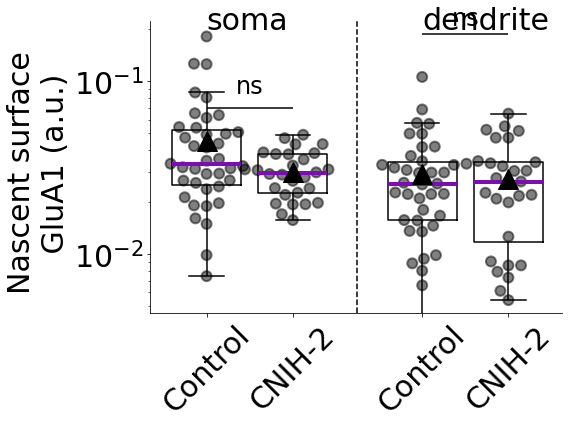

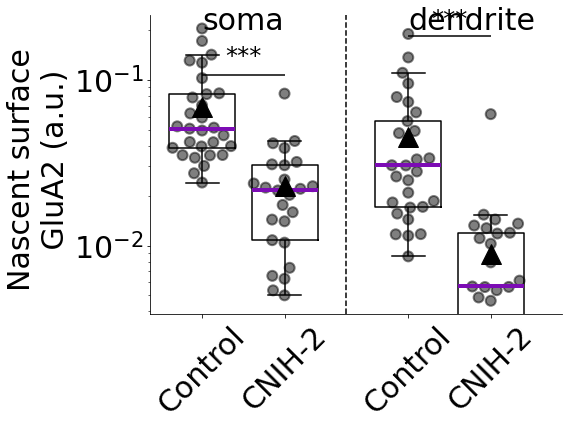

In [12]:
# compart = compartments[0]
unit_string = {compartments[0]:"in {} / $\mu m^2$".format(compartments[0]),compartments[1]:"{} / $ \mu m$".format(compartments[1])}
for subu in subunits:
    # for compart in compartments:
    xlab = ""
    title = ""#subu#"{}".format(compart)
    ylab = "Nascent surface \n {} (a.u.)".format(subu)
    print("Subunit = {}".format(subu),newprot_density[newprot_density.subunit==subu].groupby(["treatment","compartment"])["Density"].mean())
    SwarmBoxCombo(newprot_density[newprot_density.subunit==subu],
                  x = "compartment",
                  y = "Density",
                  fbase="Fig_cnih2_shrna_surf_{}_density".format(subu),
                  xlabel=xlab,
                  ylabel=ylab,
                  title=title,
                  Num = False)
